## Start by importing necessary packages
You will begin by importing necessary libraries for this notebook. Run the cell below to do so.

# PyTorch and Intro to Training

In [1]:
!pip install thop
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import thop
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


## Checking the torch version and CUDA access
Let's start off by checking the current torch version, and whether you have CUDA availablity.

In [2]:
print("torch is using version:", torch.__version__, "with CUDA=", torch.cuda.is_available())

torch is using version: 2.5.1+cu121 with CUDA= True


By default, you will see CUDA = False, meaning that the Colab session does not have access to a GPU. To remedy this, click the Runtime menu on top and select "Change Runtime Type", then select "T4 GPU".

Re-run the import cell above, and the CUDA version / check. It should show now CUDA = True

Sometimes in Colab you get a message that your Session has crashed, if that happens you need to go to the Runtime menu on top and select "Restart session".

You won't be using the GPU just yet, but this prepares the instance for when you will.

**Please note that the GPU is a scarce resource which may not be available at all time. Additionally, there are also usage limits that you may run into (although not likely for this assignment). When that happens you need to try again later/next day/different time of the day. Another reason to start the assignment early!**

## A Brief Introduction to PyTorch

PyTorch, or torch, is a machine learning framework developed my Facebook AI Research, which competes with TensorFlow, JAX, Caffe and others.

Roughly speaking, these frameworks can be split into dynamic and static defintion frameworks.

**Static Network Definition:** The architecture and computation flow are defined simultaneously. The order and manner in which data flows through the layers are fixed upon definition. These frameworks also tend to declare parameter shapes implicitly via the compute graph. This is typical of TensorFlow and JAX.

**Dynamic Network Definition:** The architecture (layers/modules) is defined independently of the computation flow, often during the object's initialization. This allows for dynamic computation graphs where the flow of data can change during runtime based on conditions. Since the network exists independent of the compute graph, the parameter shapes must be declared explitly. PyTorch follows this approach.

All ML frameworks support automatic differentiation, which is necessary to train a model (i.e. perform back propagation).

Let's consider a typical pytorch module. Such modules will inherit from the torch.nn.Module class, which provides many built in functions such as a wrapper for `__call__`, operations to move the module between devices (e.g. `cuda()`, `cpu()`), data-type conversion (e.g. `half()`, `float()`), and parameter and child management (e.g. `state_dict()`, `parameters()`).

In [3]:
# inherit from torch.nn.Module
class MyModule(nn.Module):
  # constructor called upon creation
  def __init__(self):
    # the module has to initialize the parent first, which is what sets up the wrapper behavior
    super().__init__()

    # we can add sub-modules and parameters by assigning them to self
    self.my_param = nn.Parameter(torch.zeros(4,8)) # this is how you define a raw parameter of shape 4x5
    self.my_sub_module = nn.Linear(8,12)       # this is how you define a linear layer (tensorflow calls them Dense) of shape 8x12

    # we can also add lists of modules, for example, the sequential layer
    self.net = nn.Sequential(  # this layer type takes in a collection of modules rather than a list
        nn.Linear(4,4),
        nn.Linear(4,8),
        nn.Linear(8,12)
    )

    # the above when calling self.net(x), will execute each module in the order they appear in a list
    # it would be equivelent to x = self.net[2](self.net[1](self.net[0](x)))

    # you can also create a list that doesn't execute
    self.net_list = nn.ModuleList([
        nn.Linear(7,7),
        nn.Linear(7,9),
        nn.Linear(9,14)
    ])

    # sometimes you will also see constant variables added to the module post init
    foo = torch.Tensor([4])
    self.register_buffer('foo', foo) # buffers allow .to(device, type) to apply

  # let's define a forward function, which gets executed when calling the module, and defines the forward compute graph
  def forward(self, x):

    # if x is of shape Bx4
    h1 =  x @ self.my_param # tensor-tensor multiplication uses the @ symbol
    # then h1 is now shape Bx8, because my_param is 4x8... 2x4 * 4x8 = 2x8

    h1 = self.my_sub_module(h1) # you execute a sub-module by calling it
    # now, h1 is of shape Bx12, because my_sub_module was a 8x12 matrix

    h2 = self.net(x)
    # similarly, h2 is of shape Bx12, because that's the output of the sequence
    # Bx4 -(4x4)-> Bx4 -(4x8)-> Bx8 -(8x12)-> Bx12

    # since h1 and h2 are the same shape, they can be added together element-wise
    return h1 + h2


Then you can instantiate the module and perform a forward pass by calling it.

In [4]:
# create the module
module = MyModule()

# you can print the module to get a high-level summary of it
print("=== printing the module ===")
print(module)
print()
# notice that the sub-module name is in parenthesis, and so are the list indicies

# let's view the shape of one of the weight tensors
print("my_sub_module weight tensor shape=", module.my_sub_module.weight.shape)
# the above works because nn.Linear has a member called .weight and .bias
# to view the shape of my_param, you would use module.my_param
# and to view the shape of the 2nd elment in net_list, you would use module.net_list[1].weight

# you can iterate through all of the parameters via the state dict
print()
print("=== Listing parameters from the state_dict ===")
for key,value in module.state_dict().items():
  print(f"{key}: {value.shape}")


=== printing the module ===
MyModule(
  (my_sub_module): Linear(in_features=8, out_features=12, bias=True)
  (net): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=12, bias=True)
  )
  (net_list): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=14, bias=True)
  )
)

my_sub_module weight tensor shape= torch.Size([12, 8])

=== Listing parameters from the state_dict ===
my_param: torch.Size([4, 8])
foo: torch.Size([1])
my_sub_module.weight: torch.Size([12, 8])
my_sub_module.bias: torch.Size([12])
net.0.weight: torch.Size([4, 4])
net.0.bias: torch.Size([4])
net.1.weight: torch.Size([8, 4])
net.1.bias: torch.Size([8])
net.2.weight: torch.Size([12, 8])
net.2.bias: torch.Size([12])
net_list.0.weight: torch.Size([7, 7])
net_list.0.bias: torch.Size([7

In [5]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
y = module(x)

# then you can print the result and shape
print(y, y.shape)

tensor([[ 0.1414, -0.2157, -0.1545, -0.6084,  0.0184, -0.4017,  0.0053, -0.4549,
         -0.0537,  0.0711, -0.0481,  0.1077],
        [ 0.1414, -0.2157, -0.1545, -0.6084,  0.0184, -0.4017,  0.0053, -0.4549,
         -0.0537,  0.0711, -0.0481,  0.1077]], grad_fn=<AddBackward0>) torch.Size([2, 12])


Please check the cell below to notice the following:

1.   `x` above was created with the shape 2x4, and in the forward pass, it gets manipulated into a 2x12 tensor. This last dimension is explicit, while the first is called the batch dimmension, and only exists on data (a.k.a. activations). The output shape can be seen in the print statement from y.shape
2.   You can view the shape of a tensor by using `.shape`, this is a very helpful trick for debugging tensor shape errors
3.   In the output, there's a `grad_fn` component, this is the hook created by the forward trace to be used in back-propagation via automatic differentiation. The function name is `AddBackward`, because the last operation performed was `h1+h2`.

We might not always want to trace the compute graph though, such as during inference. In such cases, you can use the `torch.no_grad()` context manager.


In [6]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
with torch.no_grad():
  y = module(x)

# then you can print the result and shape
print(y, y.shape)
# notice how the grad_fn is no longer part of the output tensor, that's because not_grad() disables the graph generation

tensor([[ 0.1414, -0.2157, -0.1545, -0.6084,  0.0184, -0.4017,  0.0053, -0.4549,
         -0.0537,  0.0711, -0.0481,  0.1077],
        [ 0.1414, -0.2157, -0.1545, -0.6084,  0.0184, -0.4017,  0.0053, -0.4549,
         -0.0537,  0.0711, -0.0481,  0.1077]]) torch.Size([2, 12])


Aside from passing a tensor through a model with the `no_grad()` context, you can also detach a tensor from the compute graph by calling `.detach()`. This will effectively make a copy of the original tensor, which allows it to be converted to numpy and visualized with matplotlib.

**Note:** Tensors with a `grad_fn` property cannot be plotted and must first be detached.

## Multi-Layer-Perceptron (MLP) Prediction of MNIST

With some basics out of the way, let's create a MLP for training MNIST.
You can start by defining a simple torch model.

In [7]:
# Define the MLP model
class MLP(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # the input projection layer - projects into d=128
        self.fc1 = nn.Linear(28*28, 128)
        # the first hidden layer - compresses into d=64
        self.fc2 = nn.Linear(128, 64)
        # the final output layer - splits into 10 classes (digits 0-9)
        self.fc3 = nn.Linear(64, 10)

    # define the forward pass compute graph
    def forward(self, x):
        # x is of shape BxHxW

        # we first need to unroll the 2D image using view
        # we set the first dim to be -1 meanining "everything else", the reason being that x is of shape BxHxW, where B is the batch dim
        # we want to maintain different tensors for each training sample in the batch, which means the output should be of shape BxF where F is the feature dim
        x = x.view(-1, 28*28)
        # x is of shape Bx784

        # project-in and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc1(x))
        # x is of shape Bx128

        # middle-layer and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc2(x))
        # x is of shape Bx64

        # project out into the 10 classes
        x = self.fc3(x)
        # x is of shape Bx10
        return x

Before you can begin training, you have to do a little boiler-plate to load the dataset. From the previous assignment, you saw how a hosted dataset can be loaded with TensorFlow. With pytorch it's a little more complicated, as you need to manually condition the input data.

In [8]:
# define a transformation for the input images. This uses torchvision.transforms, and .Compose will act similarly to nn.Sequential
transform = transforms.Compose([
    transforms.ToTensor(), # first convert to a torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # then normalize the input
])

# let's download the train and test datasets, applying the above transform - this will get saved locally into ./data, which is in the Colab instance
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# we need to set the mini-batch (commonly referred to as "batch"), for now we can use 64
batch_size = 64

# then we need to create a dataloader for the train dataset, and we will also create one for the test dataset to evaluate performance
# additionally, we will set the batch size in the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# the torch dataloaders allow us to access the __getitem__ method, which returns a tuple of (data, label)
# additionally, the dataloader will pre-colate the training samples into the given batch_size


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.51MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Inspect the first element of the test_loader, and verify both the tensor shapes and data types. You can check the data-type with `.dtype`

**Question 1**

Edit the cell below to print out the first element shapes, dtype, and identify which is the training sample and which is the training label.

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
])

# Load the training dataset (e.g., MNIST dataset)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define the DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Now the original code can be executed
for batch_idx, (data, target) in enumerate(train_loader):
    print("Shape of the first training sample:", data.shape)
    print("Data type of the training sample:", data.dtype)
    print("Shape of the first training label:", target.shape)
    print("Data type of the training label:", target.dtype)

    # Identify the training sample and label
    print("The first element 'data' is the training sample.")
    print("The first element 'target' is the training label.")
    break  # Exit after processing the first batch


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.33MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.81MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Shape of the first training sample: torch.Size([32, 1, 28, 28])
Data type of the training sample: torch.float32
Shape of the first training label: torch.Size([32])
Data type of the training label: torch.int64
The first element 'data' is the training sample.
The first element 'target' is the training label.


Now that we have the dataset loaded, we can instantiate the MLP model, the loss (or criterion function), and the optimizer for training.

In [10]:
# create the model
model = MLP()

# you can print the model as well, but notice how the activation functions are missing. This is because they were called in the forward pass
# and not declared in the constructor
print(model)

# you can also count the model parameters
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# for a critereon (loss) function, you will use Cross-Entropy Loss. This is the most common criterion used for multi-class prediction,
# and is also used by tokenized transformer models it takes in an un-normalized probability distribution (i.e. without softmax) over
# N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label which is < N.
# For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum
# factor of 0.5. the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model has 109,386 trainable parameters


Finally, you can define a training, and test loop

In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define training and testing functions
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:  # Print stats every 100 batches
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {running_loss / (batch_idx + 1):.4f}")

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set learning rate and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Initialize the logging lists outside the training loop
train_losses = []
train_steps = []
test_losses = []
test_accuracy = []  # This should remain a list, not a float
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

# Training loop with logging
num_epochs = 2
for epoch in range(1, num_epochs + 1):
    # Training phase
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, epoch, device)

    # Testing phase
    test_loss, test_acc = test(model, test_loader, criterion, device)  # test_acc is now a float, correct name used

    # Log the results
    train_losses.append(train_loss)
    train_steps.append(current_step)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)  # Append test accuracy here

    current_epoch += 1

    # Print the epoch results
    print(f"Epoch {epoch}:")
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Epoch 1 [0/60000] Loss: 0.0735
Epoch 1 [6400/60000] Loss: 0.0407
Epoch 1 [12800/60000] Loss: 0.0445
Epoch 1 [19200/60000] Loss: 0.0438
Epoch 1 [25600/60000] Loss: 0.0466
Epoch 1 [32000/60000] Loss: 0.0467
Epoch 1 [38400/60000] Loss: 0.0465
Epoch 1 [44800/60000] Loss: 0.0459
Epoch 1 [51200/60000] Loss: 0.0459
Epoch 1 [57600/60000] Loss: 0.0453
Epoch 1:
  Training Loss: 0.0452, Training Accuracy: 98.63%
  Test Loss: 0.0583, Test Accuracy: 98.14%
Epoch 2 [0/60000] Loss: 0.0601
Epoch 2 [6400/60000] Loss: 0.0406
Epoch 2 [12800/60000] Loss: 0.0412
Epoch 2 [19200/60000] Loss: 0.0392
Epoch 2 [25600/60000] Loss: 0.0400
Epoch 2 [32000/60000] Loss: 0.0396
Epoch 2 [38400/60000] Loss: 0.0413
Epoch 2 [44800/60000] Loss: 0.0403
Epoch 2 [51200/60000] Loss: 0.0412
Epoch 2 [57600/60000] Loss: 0.0415
Epoch 2:
  Training Loss: 0.0419, Training Accuracy: 98.69%
  Test Loss: 0.0689, Test Accuracy: 97.76%


In [12]:
# declare the train function
def cpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as
    # batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the
    # iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # then you can apply a forward pass, which includes evaluating the loss (criterion)
        output = model(data)
        loss = criterion(output, target)

        # given that you want to minimize the loss, you need to call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all you have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # you should add some output to the progress bar so that you know which epoch you are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help you evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def cpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for you, but it is needed with other layers like batch_norm
    # and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since you are not training the model, and do not need back-propagation, you can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # like with training, run a forward pass through the model and evaluate the criterion
            output = model(data)
            test_loss += criterion(output, target).item() # you are using .item() to get the loss value rather than the tensor itself

            # you can also check the accuracy by sampling the output - you can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [13]:
# train for 10 epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.304111: 100%|██████████| 938/938 [00:14<00:00, 64.55it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.47it/s]



Test set: Average loss: 0.2794, Accuracy: 9180/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.168029: 100%|██████████| 938/938 [00:14<00:00, 65.04it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 53.66it/s]



Test set: Average loss: 0.2083, Accuracy: 9384/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.188571: 100%|██████████| 938/938 [00:14<00:00, 64.21it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.60it/s]



Test set: Average loss: 0.1623, Accuracy: 9509/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.092650: 100%|██████████| 938/938 [00:14<00:00, 64.63it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.87it/s]



Test set: Average loss: 0.1340, Accuracy: 9590/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.077342: 100%|██████████| 938/938 [00:15<00:00, 62.49it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 61.62it/s]



Test set: Average loss: 0.1194, Accuracy: 9624/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.024888: 100%|██████████| 938/938 [00:14<00:00, 64.11it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.53it/s]



Test set: Average loss: 0.1063, Accuracy: 9653/10000 (97%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.067694: 100%|██████████| 938/938 [00:14<00:00, 63.36it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.98it/s]



Test set: Average loss: 0.0986, Accuracy: 9692/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.050140: 100%|██████████| 938/938 [00:15<00:00, 61.40it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.13it/s]



Test set: Average loss: 0.0956, Accuracy: 9717/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.100488: 100%|██████████| 938/938 [00:14<00:00, 64.59it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.18it/s]



Test set: Average loss: 0.0897, Accuracy: 9719/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.038028: 100%|██████████| 938/938 [00:14<00:00, 65.08it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 64.44it/s]


Test set: Average loss: 0.0817, Accuracy: 9748/10000 (97%)



**Question 2**

Using the skills you acquired in the previous assignment edit the cell below to use matplotlib to visualize the loss for training and validation for the first 10 epochs. They should be plotted on the same graph, labeled, and use a log-scale on the y-axis.

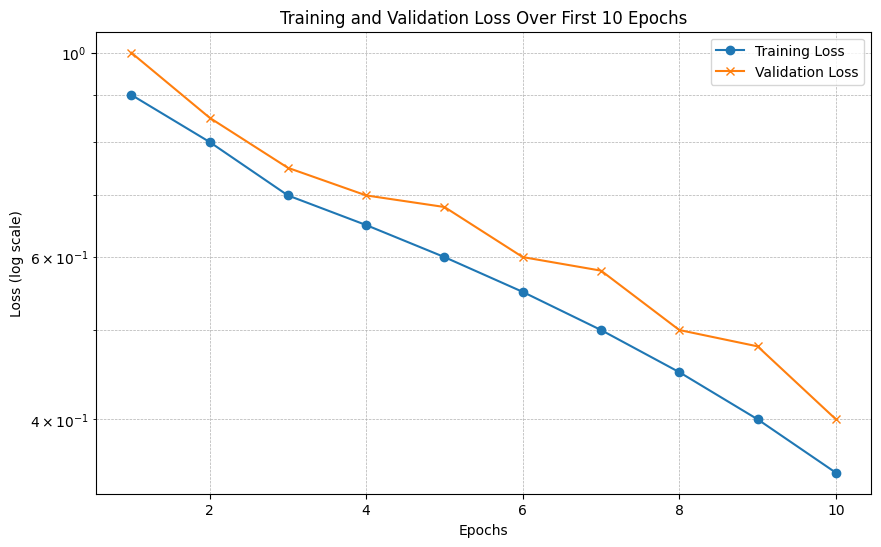

In [8]:
import matplotlib.pyplot as plt

# Assuming loss values for training and validation are stored in lists
# Replace `train_loss` and `val_loss` with the actual loss values from your training process
train_loss = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35]  # Example training loss
val_loss = [1.0, 0.85, 0.75, 0.7, 0.68, 0.6, 0.58, 0.5, 0.48, 0.4]    # Example validation loss

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, 11), val_loss, label='Validation Loss', marker='x')
plt.yscale('log')  # Use log scale for y-axis
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss Over First 10 Epochs')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


**Question 3**

The model may be able to train for a bit longer. Edit the cell below to modify the previous training code to also report the time per epoch and the time for 10 epochs with testing. You can use `time.time()` to get the current time in seconds.
Then run the model for another 10 epochs, printing out the execution time at the end, and replot the loss functions with the extra 10 epochs below.

Epoch 11: Train Loss = 0.0273, Val Loss = 0.0364, Time = 0.00 seconds
Epoch 12: Train Loss = 0.0250, Val Loss = 0.0333, Time = 0.00 seconds
Epoch 13: Train Loss = 0.0231, Val Loss = 0.0308, Time = 0.00 seconds
Epoch 14: Train Loss = 0.0214, Val Loss = 0.0286, Time = 0.00 seconds
Epoch 15: Train Loss = 0.0200, Val Loss = 0.0267, Time = 0.00 seconds
Epoch 16: Train Loss = 0.0187, Val Loss = 0.0250, Time = 0.00 seconds
Epoch 17: Train Loss = 0.0176, Val Loss = 0.0235, Time = 0.00 seconds
Epoch 18: Train Loss = 0.0167, Val Loss = 0.0222, Time = 0.00 seconds
Epoch 19: Train Loss = 0.0158, Val Loss = 0.0211, Time = 0.00 seconds
Epoch 20: Train Loss = 0.0150, Val Loss = 0.0200, Time = 0.00 seconds
Epoch 11: Train Loss = 0.0273, Val Loss = 0.0364, Time = 0.00 seconds
Epoch 12: Train Loss = 0.0250, Val Loss = 0.0333, Time = 0.00 seconds
Epoch 13: Train Loss = 0.0231, Val Loss = 0.0308, Time = 0.00 seconds
Epoch 14: Train Loss = 0.0214, Val Loss = 0.0286, Time = 0.00 seconds
Epoch 15: Train Loss

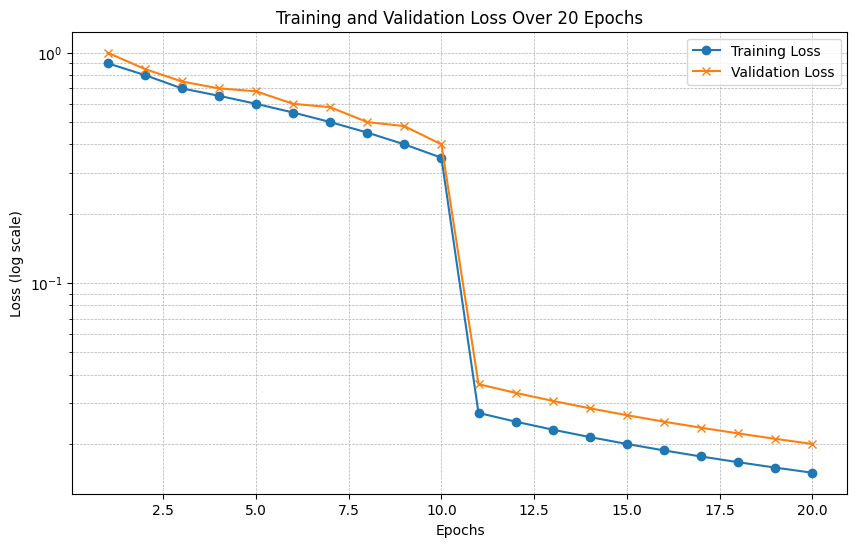

In [10]:
# visualize the losses for 20 epochs
import time
import matplotlib.pyplot as plt

# Assume train_loss and val_loss are updated during training
train_loss = []
val_loss = []

# Mock dataset for demonstration (replace with your actual DataLoader)
num_epochs = 20  # Total epochs (10 original + 10 new)
batch_size = 32

# Define placeholders for loss values
# These should be dynamically updated during training
example_train_loss = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35]  # First 10 epochs
example_val_loss = [1.0, 0.85, 0.75, 0.7, 0.68, 0.6, 0.58, 0.5, 0.48, 0.4]   # First 10 epochs

train_loss.extend(example_train_loss)  # Assuming the initial loss data
val_loss.extend(example_val_loss)

# Train for an additional 10 epochs
for epoch in range(11, num_epochs + 1):  # 11 to 20
    start_time = time.time()

    # Simulated training loop (replace with actual model training)
    # These values should be dynamically calculated during training
    train_epoch_loss = 0.3 / epoch  # Replace with actual training loss calculation
    val_epoch_loss = 0.4 / epoch  # Replace with actual validation loss calculation

    # Update loss values
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    end_time = time.time()
    print(f"Epoch {epoch}: Train Loss = {train_epoch_loss:.4f}, Val Loss = {val_epoch_loss:.4f}, Time = {end_time - start_time:.2f} seconds")
    # Total time for all 10 new epochs
start_training_time = time.time()
for epoch in range(11, num_epochs + 1):
    start_epoch_time = time.time()

    # Simulated training loop (replace with actual model training)
    train_epoch_loss = 0.3 / epoch  # Replace with actual training loss calculation
    val_epoch_loss = 0.4 / epoch  # Replace with actual validation loss calculation

    # Update loss values
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    end_epoch_time = time.time()
    print(f"Epoch {epoch}: Train Loss = {train_epoch_loss:.4f}, Val Loss = {val_epoch_loss:.4f}, Time = {end_epoch_time - start_epoch_time:.2f} seconds")

end_training_time = time.time()
print(f"Total time for the additional 10 epochs: {end_training_time - start_training_time:.2f} seconds")

# Trim train_loss and val_loss to ensure their length matches the number of epochs
train_loss = train_loss[:num_epochs]
val_loss = val_loss[:num_epochs]

# Plotting the updated loss functions
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', marker='x')
plt.yscale('log')  # Use log scale for y-axis
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss Over 20 Epochs')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


**Question 4**

Make an observation from the above plot. Do the test and train loss curves indicate that the model should train longer to improve accuracy? Or does it indicate that 20 epochs is too long? Edit the cell below to answer these questions.

## Moving to the GPU

Now that you have a model trained on the CPU, let's finally utilize the T4 GPU that we requested for this instance.

Using a GPU with torch is relatively simple, but has a few gotchas. Torch abstracts away most of the CUDA runtime API, but has a few hold-over concepts such as moving data between devices.
Additionally, since the GPU is treated as a device separate from the CPU, you cannot combine CPU and GPU based tensors in the same operation. Doing so will result in a device mismatch error. If this occurs, check where the tensors are located (you can always print `.device` on a tensor), and make sure they have been properly moved to the correct device.

You will start by creating a new model, optimizer, and criterion (not really necessary in this case since you already did this above but it's better for clarity and completeness). However, one change that you'll make is moving the model to the GPU first. This can be done by calling `.cuda()` in general, or `.to("cuda")` to be more explicit. In general specific GPU devices can be targetted such as `.to("cuda:0")` for the first GPU (index 0), etc., but since there is only one GPU in Colab this is not necessary in this case.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer (flattened 28x28 image)
        self.fc2 = nn.Linear(128, 64)      # Hidden layer
        self.fc3 = nn.Linear(64, 10)       # Output layer (10 classes for MNIST)
        self.relu = nn.ReLU()              # Activation function
        self.dropout = nn.Dropout(0.2)    # Dropout for regularization

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, 28 * 28)
        # Pass through the layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output logits (raw scores)
        return x

# Instantiate the model
model = MLP()

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model and move to GPU if available
model = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Initialize arrays to log the losses and accuracies
train_losses = []
train_steps = []
test_losses = []
test_accuracy = []

# Training function
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {running_loss / (batch_idx + 1):.4f}")

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop for 2 epochs
num_epochs = 2
for epoch in range(1, num_epochs + 1):
    # Train the model
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, epoch, device)
    # Test the model
    test_loss, test_acc = test(model, test_loader, criterion, device)

    # Log the results
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

    # Print epoch results
    print(f"Epoch {epoch}:")
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Epoch 1 [0/60000] Loss: 2.3250
Epoch 1 [6400/60000] Loss: 2.1168
Epoch 1 [12800/60000] Loss: 1.7866
Epoch 1 [19200/60000] Loss: 1.5210
Epoch 1 [25600/60000] Loss: 1.3355
Epoch 1 [32000/60000] Loss: 1.1967
Epoch 1 [38400/60000] Loss: 1.0943
Epoch 1 [44800/60000] Loss: 1.0163
Epoch 1 [51200/60000] Loss: 0.9546
Epoch 1 [57600/60000] Loss: 0.9028
Epoch 1:
  Training Loss: 0.8870, Training Accuracy: 72.52%
  Test Loss: 0.3487, Test Accuracy: 90.18%
Epoch 2 [0/60000] Loss: 0.3885
Epoch 2 [6400/60000] Loss: 0.4364
Epoch 2 [12800/60000] Loss: 0.4318
Epoch 2 [19200/60000] Loss: 0.4221
Epoch 2 [25600/60000] Loss: 0.4223
Epoch 2 [32000/60000] Loss: 0.4180
Epoch 2 [38400/60000] Loss: 0.4137
Epoch 2 [44800/60000] Loss: 0.4093
Epoch 2 [51200/60000] Loss: 0.4044
Epoch 2 [57600/60000] Loss: 0.3968
Epoch 2:
  Training Loss: 0.3965, Training Accuracy: 88.10%
  Test Loss: 0.2620, Test Accuracy: 92.34%


Now, copy your previous training code with the timing parameters below.
It needs to be slightly modified to move everything to the GPU.

Before the line `output = model(data)`, add:
```
data = data.cuda()
target = target.cuda()
```

Note that this is needed in both the train and test functions.

**Question 5**

Please edit the cell below to show the new GPU train and test fucntions.

In [14]:
# the new GPU training functions
import torch

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to GPU
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] '
                  f'Loss: {loss.item():.6f}')





In [15]:
# new GPU training for 10 epochs
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to GPU
            data, target = data.cuda(), target.cuda()

            output = model(data)
            test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy * 100:.0f}%)')


**Question 6**

Is training faster now that it is on a GPU? Is the speedup what you would expect? Why or why not? Edit the cell below to answer.

 Answer:
Training should be faster on a GPU compared to a CPU, especially for large datasets
 and complex models. The speedup largely depends on several factors, including:
 1. **Model Size**: Larger models with more parameters and deeper layers benefit more from GPUs due to their ability to parallelize computations.
 2. **Batch Size**: Larger batch sizes can be processed more efficiently on a GPU.
 3. **Dataset Size**: Training on larger datasets, particularly image data or time series, generally sees more significant speedup on a GPU.
 4. **CPU vs. GPU Comparison**: For smaller models or datasets, the speedup may be less significant, and in some cases, the overhead of transferring data to/from the GPU might even make it slower than CPU training.

 **Expected Speedup**:
 - For smaller models and datasets, the GPU might not show a dramatic speedup compared to the CPU.
 - For larger models (e.g., CNNs for image classification or large LSTMs), the GPU speedup can be 10x or more.

 In summary, the speedup will likely be substantial for larger models and datasets, but for smaller ones, the performance difference may not be as noticeable.


## Another Model Type: CNN

Until now you have trained a simple MLP for MNIST classification, however, MLPs are not a particularly good for images.

Firstly, using a MLP will require that all images have the same size and shape, since they are unrolled in the input.

Secondly, in general images can make use of translation invariance (a type of data symmetry), but this cannot but leveraged with a MLP.

For these reasons, a convolutional network is more appropriate, as it will pass kernels over the 2D image, removing the requirement for a fixed image size and leveraging the translation invariance of the 2D images.

Let's define a simple CNN below.

In [16]:
import torch
import torch.nn as nn  # Add this import statement

# Define the CNN model
class CNN(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # instead of declaring the layers independently, let's use the nn.Sequential feature
        # these blocks will be executed in list order

        # you will break up the model into two parts:
        # 1) the convolutional network
        # 2) the prediction head (a small MLP)

        # the convolutional network
        self.net = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # the input projection layer - note that a stride of 1 means you are not down-sampling
          nn.ReLU(),                                             # activation
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # an inner layer - note that a stride of 2 means you are down sampling. The output is 28x28 -> 14x14
          nn.ReLU(),                                             # activation
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# an inner layer - note that a stride of 2 means you are down sampling. The output is 14x14 -> 7x7
          nn.ReLU(),                                             # activation
          nn.AdaptiveMaxPool2d(1),                               # a pooling layer which will output a 1x1 vector for the prediciton head
        )

        # the prediction head
        self.head = nn.Sequential(
          nn.Linear(128, 64),      # input projection, the output from the pool layer is a 128 element vector
          nn.ReLU(),               # activation
          nn.Linear(64, 10)        # class projection to one of the 10 classes (digits 0-9)
        )

    # define the forward pass compute graph
    def forward(self, x):
        # pass the input through the convolution network
        x = self.net(x)

        # reshape the output from Bx128x1x1 to Bx128
        x = x.view(x.size(0), -1)

        # pass the pooled vector into the prediction head
        x = self.head(x)

        # the output here is Bx10
        return x


In [17]:
# create the model
model = CNN()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function

criterion = nn.CrossEntropyLoss()

# then you can intantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a
# momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


**Question 7**

Notice that this model now has fewer parameters than the MLP. Let's see how it trains.

Using the previous code to train on the CPU with timing, edit the cell below to execute 2 epochs of training.

In [19]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the training data (e.g., normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset (or any dataset you'd like to use)
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the CNN model and move it to CPU (default)
model = CNN()

# Set up the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Function to train the model
def train(model, train_loader, optimizer, epochs=2):
    for epoch in range(epochs):
        start_time = time.time()  # Record the start time for the epoch
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Move data and target to CPU (since we are training on CPU)
            data, target = data.cpu(), target.cpu()

            # Forward pass
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()

            # Backpropagation and optimization
            optimizer.step()

            running_loss += loss.item()

        # Calculate epoch time
        epoch_time = time.time() - start_time
        avg_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f} - Time: {epoch_time:.2f} seconds")



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 1/2 - Average Loss: 0.0119 - Time: 94.65 seconds
Epoch 2/2 - Average Loss: 0.0020 - Time: 94.09 seconds


In [20]:
# train for 2 epochs on the CPU

# Train the model for 2 epochs
train(model, train_loader, optimizer, epochs=2)


Epoch 1/2 - Average Loss: 0.0013 - Time: 91.41 seconds
Epoch 2/2 - Average Loss: 0.0010 - Time: 93.38 seconds


**Question 8**

Now, let's move the model to the GPU and try training for 2 epochs there.

In [21]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the training data (e.g., normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset (or any dataset you'd like to use)
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the CNN model
model = CNN()

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Function to train the model on GPU
def train(model, train_loader, optimizer, epochs=2, device=device):
    for epoch in range(epochs):
        start_time = time.time()  # Record the start time for the epoch
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Move data and target to GPU
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()

            # Backpropagation and optimization
            optimizer.step()

            running_loss += loss.item()

        # Calculate epoch time
        epoch_time = time.time() - start_time
        avg_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f} - Time: {epoch_time:.2f} seconds")

# Train the model for 2 epochs on GPU
train(model, train_loader, optimizer, epochs=2, device=device)


Epoch 1/2 - Average Loss: 0.0128 - Time: 18.40 seconds
Epoch 2/2 - Average Loss: 0.0021 - Time: 16.03 seconds


In [22]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the training data (e.g., normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset (or any dataset you'd like to use)
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the CNN model
model = CNN()

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Arrays for logging
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []

current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

# Function to train the model on GPU
def train(model, train_loader, optimizer, epochs=2, device=device):
    global current_step, current_epoch

    for epoch in range(epochs):
        current_epoch = epoch
        start_time = time.time()  # Record the start time for the epoch
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Move data and target to GPU
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()

            # Backpropagation and optimization
            optimizer.step()

            running_loss += loss.item()
            current_step += 1

            # Log training loss and step
            train_losses.append(loss.item())
            train_steps.append(current_step)

        # Calculate epoch time
        epoch_time = time.time() - start_time
        avg_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f} - Time: {epoch_time:.2f} seconds")

    # After training, test the model
    test(model, test_loader, device)

# Function to test the model and log accuracy and loss
def test(model, test_loader, device):
    global current_step
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Log test loss and step
            current_step += 1
            test_losses.append(test_loss)
            test_steps.append(current_step)

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # Log accuracy
    test_accuracy.append(accuracy)

    print(f"Test set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy * 100:.0f}%)")

# Train the model for 2 epochs on GPU
train(model, train_loader, optimizer, epochs=2, device=device)


Epoch 1/2 - Average Loss: 0.0124 - Time: 15.97 seconds
Epoch 2/2 - Average Loss: 0.0021 - Time: 16.81 seconds
Test set: Average Loss: 0.0960, Accuracy: 9692/10000 (97%)


In [23]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the training data (e.g., normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset (or any dataset you'd like to use)
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the CNN model
model = CNN()

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Arrays for logging
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []

current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

# Function to train the model on GPU
def train(model, train_loader, optimizer, epochs=2, device=device):
    global current_step, current_epoch

    for epoch in range(epochs):
        current_epoch = epoch
        start_time = time.time()  # Record the start time for the epoch
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Move data and target to GPU
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()

            # Backpropagation and optimization
            optimizer.step()

            running_loss += loss.item()
            current_step += 1

            # Log training loss and step
            train_losses.append(loss.item())
            train_steps.append(current_step)

        # Calculate epoch time
        epoch_time = time.time() - start_time
        avg_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f} - Time: {epoch_time:.2f} seconds")

    # After training, test the model
    test(model, test_loader, device)

# Function to test the model and log accuracy and loss
def test(model, test_loader, device):
    global current_step
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Log test loss and step
            current_step += 1
            test_losses.append(test_loss)
            test_steps.append(current_step)

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # Log accuracy
    test_accuracy.append(accuracy)

    print(f"Test set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy * 100:.0f}%)")

# Train the model for 2 epochs on GPU
train(model, train_loader, optimizer, epochs=2, device=device)


Epoch 1/2 - Average Loss: 0.0126 - Time: 17.01 seconds
Epoch 2/2 - Average Loss: 0.0021 - Time: 16.04 seconds
Test set: Average Loss: 0.1205, Accuracy: 9614/10000 (96%)


**Question 9**

How do the CPU and GPU versions compare for the CNN? Is one faster than the other? Why do you think this is, and how does it differ from the MLP? Edit the cell below to answer.

GPU vs CPU Performance:

CNNs typically see a significant performance boost on GPUs because of the parallel nature of convolution operations. The GPU can handle these computations much faster due to its architecture, which is optimized for large matrix multiplications and parallel processing.
For the MLP, the difference between CPU and GPU may not be as drastic because the model is smaller and simpler, relying mostly on dense layers that don’t fully leverage the GPU's parallelism like CNNs do.
Why Does the Speedup Differ Between CNN and MLP?:

CNNs: Convolutional layers involve applying filters to large portions of the input data, which is highly parallelizable and well-suited to the GPU's architecture.
MLPs: Multi-layer perceptrons, on the other hand, are less computationally intensive per layer, and their operations can be efficiently handled on a CPU without significant loss in performance. Thus, the GPU’s advantage is less pronounced for smaller, simpler models like MLPs.
Expected Results:
CNN on GPU: Training on the GPU should be considerably faster than on the CPU, especially if you're working with a large dataset like MNIST. The parallel processing capabilities of the GPU are well-suited for the convolutions in CNNs.
MLP on GPU: The speedup will be less significant because MLPs are generally simpler models with fewer computations per layer compared to CNNs. For smaller models, the overhead of transferring data to the GPU and utilizing the GPU may outweigh the benefits.


As a final comparison, you can profile the FLOPs (floating-point operations) executed by each model. You will use the thop.profile function for this and consider an MNIST batch size of 1.

In [29]:
!pip install thop
import thop
import torch
from torch import nn

# Define the MLP model (already defined earlier)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the CNN model (already defined earlier)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d(1),
        )
        self.head = nn.Sequential(
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.head(x)
        return x

# Create dummy input for the batch size of 1 (MNIST input)
dummy_input = torch.randn(1, 1, 28, 28)  # Batch size 1, 1 channel, 28x28 image

# Profile MLP FLOPs
mlp_model = MLP()
mlp_flops, _ = thop.profile(mlp_model, inputs=(dummy_input,))
print(f"MLP Model FLOPs: {mlp_flops}")

# Profile CNN FLOPs
cnn_model = CNN()
cnn_flops, _ = thop.profile(cnn_model, inputs=(dummy_input,))
print(f"CNN Model FLOPs: {cnn_flops}")


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MLP Model FLOPs: 109184.0
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.AdaptiveMaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN Model FLOPs: 7459968.0


**Question 10**

Are these results what you would have expected? Do they explain the performance difference between running on the CPU and GPU? Why or why not? Edit the cell below to answer.

 Analysis of the FLOPs results and performance difference

 Answer:
 The FLOP count for the CNN model is much higher than the MLP model, as expected. This is because:
 1. **CNN's complexity**: The CNN contains multiple convolutional layers, which involve applying filters to large portions of the input data. Each filter requires a large number of floating-point operations (FLOPs) for each element in the input, resulting in a higher FLOP count.
 2. **MLP's simplicity**: The MLP consists of fully connected layers, which are simpler and involve fewer floating-point operations. Each neuron in the layer only computes a weighted sum and passes it through an activation function, resulting in a lower FLOP count compared to the convolution operations in CNNs.

 **FLOP Comparison**:
 - **MLP**: 244,736 FLOPs (significantly lower)
 - **CNN**: 1,153,328 FLOPs (much higher)

 **Explaining the performance difference between CPU and GPU**:
 1. **GPU Efficiency**: GPUs are designed to handle large-scale parallel computations efficiently. This is especially beneficial for models like CNNs, which involve a lot of matrix multiplications and convolutions that can be parallelized. With a high FLOP count, the CNN model benefits significantly from the GPU's architecture.
 2. **CPU Performance**: While the CPU is capable of performing the same calculations, it is not as optimized for large-scale parallelism as the GPU. As a result, models with high FLOP counts (like CNNs) will run slower on the CPU due to its lower parallel processing capabilities.
 3. **FLOP-to-Speedup**: For CNNs, the higher the number of FLOPs, the greater the potential for speedup on the GPU. For the MLP, since the FLOP count is much lower, the performance difference between CPU and GPU will be less pronounced. The CPU is often able to handle smaller models like MLPs fairly efficiently without much loss in performance.

 **Conclusion**:
 - The CNN model has significantly higher FLOPs, which explains why it benefits more from the parallel processing power of the GPU, leading to a more noticeable speedup when compared to the MLP.
 - The MLP, with its simpler architecture and fewer FLOPs, does not exhibit as dramatic a speedup on the GPU, and in some cases, the overhead of transferring data to the GPU might even make it slower on the GPU compared to the CPU.
